In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from pathlib import Path
import matplotlib.pyplot as plt


In [3]:
dataset = Path(Path.cwd()).resolve().parents[1] / "introduction" / "datasets" / "spam.csv"

In [8]:
df = pd.read_csv(dataset, encoding='latin1', usecols=[0, 1], names=['is spam', 'text'])[1:]

In [10]:
df['is spam'] = df['is spam'].apply(lambda x: 0 if x == 'ham' else 1)
df.head()

,is spam,text
1,0,"Go until jurong point, crazy.. Available only ..."
2,0,Ok lar... Joking wif u oni...
3,1,Free entry in 2 a wkly comp to win FA Cup fina...
4,0,U dun say so early hor... U c already then say...
5,0,"Nah I don't think he goes to usf, he lives aro..."


### Analyzing the data

In [11]:
df.groupby('is spam').describe()

text                                                               
        count unique                                                top freq
is spam                                                                     
0        4825   4516                             Sorry, I'll call later   30
1         747    653  Please call our customer service representativ...    4

In [12]:
def percentage_digits(text):
    counter = 0
    for i in text:
        if i.isdigit():
            counter += 1
    return (counter / len(text)) * 100

df['percentage digits'] = df['text'].apply(percentage_digits)
df.head()

,is spam,text,percentage digits
1,0,"Go until jurong point, crazy.. Available only ...",0.000000
2,0,Ok lar... Joking wif u oni...,0.000000
3,1,Free entry in 2 a wkly comp to win FA Cup fina...,16.129032
4,0,U dun say so early hor... U c already then say...,0.000000
5,0,"Nah I don't think he goes to usf, he lives aro...",0.000000


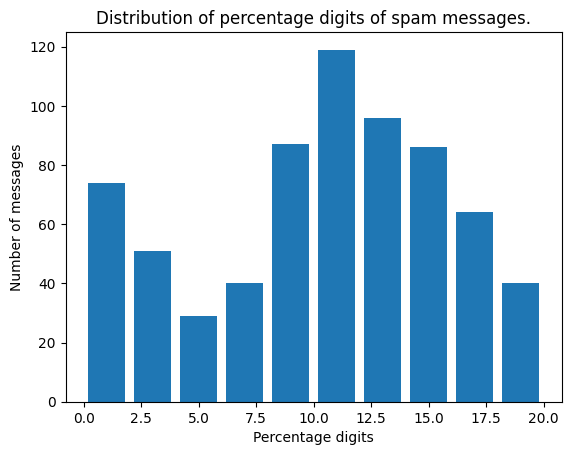

In [15]:
plt.hist(df[df['is spam'] == 1]['percentage digits'], bins=10, range=(0, 20), rwidth=0.8)
plt.xlabel('Percentage digits')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage digits of spam messages.')
plt.show()

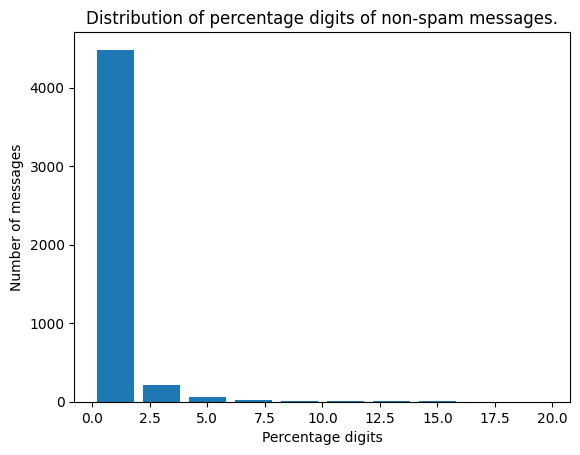

In [16]:
plt.hist(df[df['is spam'] == 0]['percentage digits'], bins=10, range=(0, 20), rwidth=0.8)
plt.xlabel('Percentage digits')
plt.ylabel('Number of messages')
plt.title('Distribution of percentage digits of non-spam messages.')
plt.show()